In [ ]:
!pip install transformers accelerate onnxruntime


In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from torch.nn.utils.rnn import pad_sequence
import string

from tqdm import tqdm

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
df = pd.read_csv("C:/Users/roaam/Downloads/hyprid/Final_new_dataset/Final_dataset.csv")



In [4]:
df['status'].value_counts()

status
Normal                  16020
Depression              15086
Suicidal                10641
Anxiety                  3613
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [5]:
df.isnull().sum()

statement    0
status       0
dtype: int64

# Clean Text Function

In [6]:
# import re

# def clean_status(text):
#     if pd.isna(text):
#         return None

#     t = text.strip().lower()
#     t = re.sub(r'[^a-zA-Z]+', ' ', t).strip()   # remove symbols, normalize
#     t = re.sub(r"[^A-Za-z0-9\s]", "", t)
#     # remove digits
#     t = re.sub(r"\d+", "", t)
#     # normalize spaces
#     t = re.sub(r"\s+", " ", t)

#     # normalization dictionary
#     mapping = {
#         "normal": "Normal",
#         "depression": "Depression",
#         "depressed": "Depression",
#         "suicidal": "Suicidal",
#         "suicide": "Suicidal",
#         "anxiety": "Anxiety",
#         "anxious": "Anxiety",
#         "stress": "Stress",
#         "stressed": "Stress",
#         "bi polar": "Bi-Polar",
#         "bipolar": "Bi-Polar",
#         "bi polar disorder": "Bi-Polar",
#         "personality disorder": "Personality Disorder",
#         "personality": "Personality Disorder",
#         "pd": "Personality Disorder",
#     }

#     # find exact match first
#     if t in mapping:
#         return mapping[t]

#     # fuzzy fallback (contains keyword)
#     if "bipolar" in t or "bi polar" in t:
#         return "Bi-Polar"
#     if "personality" in t:
#         return "Personality Disorder"

#     return None   # invalid / unrecognized label


In [7]:
# df['status_clean'] = df['status'].apply(clean_status)

In [8]:
# df = df.dropna(subset=['statement']).reset_index(drop=True)
# df['status'] = df['status_clean']
# df = df.drop(columns=['status_clean'])

# df['status'].value_counts()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51049 entries, 0 to 51048
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  51049 non-null  object
 1   status     51049 non-null  object
dtypes: object(2)
memory usage: 797.8+ KB


In [10]:
print(df.isnull().sum())

statement    0
status       0
dtype: int64


In [11]:
# df = df.drop(columns=['Unnamed: 0'])


In [12]:
df

,statement,status
0,"['oh', 'my', 'gosh']",Anxiety
1,"['trouble', 'sleep', 'confused', 'mind', 'rest...",Anxiety
2,"['all', 'wrong', 'back', 'off', 'dear', 'forwa...",Anxiety
3,"['I', 've', 'shift', 'my', 'focus', 'to', 'som...",Anxiety
4,"['I', 'm', 'restless', 'and', 'restless', 'its...",Anxiety
...,...,...
51044,"['anxiety', 'cause', 'faintness', 'when', 'sta...",Anxiety
51045,"['anxiety', 'heart', 'symptom', 'do', 'anyone'...",Anxiety
51046,"['travel', 'anxiety', 'hi', 'all', 'long', 'ti...",Anxiety
51047,"['fomo', 'from', 'thing', 'I', 'm', 'not', 'in...",Anxiety


In [13]:
from sklearn.utils import resample

In [14]:
import pandas as pd

# Step 1: Optional - sample a subset if dataset is large
df_sample = df.sample(n=min(20000, len(df)), random_state=42)

# Step 2: Determine the target size for resampling
class_counts = df_sample['status'].value_counts()
majority_size = class_counts.max()  # Automatically pick the largest class
print(f"Target size for all classes: {majority_size}")

# Step 3: Resampling function
def resample_class(df_subset, target_size):
    """
    Resample a dataframe subset to the target size.
    Oversample if smaller, undersample if larger.
    """
    if len(df_subset) == 0:
        return df_subset
    if len(df_subset) >= target_size:
        # Undersample
        return df_subset.sample(n=target_size, random_state=42, replace=False)
    else:
        # Oversample
        return resample(df_subset, replace=True, n_samples=target_size, random_state=42)

# Step 4: Apply resampling to all classes
resampled_dfs = []
for status_val in class_counts.index:
    df_class = df_sample[df_sample['status'] == status_val]
    resampled_df = resample_class(df_class, majority_size)
    print(f"Status {status_val}: Original {len(df_class)} → Resampled {len(resampled_df)}")
    resampled_dfs.append(resampled_df)

# Step 5: Combine resampled data
df_balanced = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)

# Step 6: Keep only relevant columns
data = df_balanced[['statement', 'status']]


Target size for all classes: 6353
Status Normal: Original 6353 → Resampled 6353
Status Depression: Original 5912 → Resampled 6353
Status Suicidal: Original 4101 → Resampled 6353
Status Anxiety: Original 1389 → Resampled 6353
Status Bipolar: Original 1019 → Resampled 6353
Status Stress: Original 886 → Resampled 6353
Status Personality disorder: Original 340 → Resampled 6353


In [15]:
print(data['status'].value_counts())
print(f"\nTotal samples: {len(data)}")


status
Normal                  6353
Depression              6353
Suicidal                6353
Anxiety                 6353
Bipolar                 6353
Stress                  6353
Personality disorder    6353
Name: count, dtype: int64

Total samples: 44471


In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])


In [17]:
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Anxiety: 0
Bipolar: 1
Depression: 2
Normal: 3
Personality disorder: 4
Stress: 5
Suicidal: 6


# Load Dataset

In [18]:
X = data['statement']
y = data['status_encoded']

In [19]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(
    data,
    test_size=0.20,
    stratify=data["status_encoded"],
    random_state=42
)


valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["status_encoded"],
    random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")
print(f"Total: {len(train_df) + len(valid_df) + len(test_df)}")

Train size: 35576
Validation size: 4447
Test size: 4448
Total: 44471


# Dataset / Tokenizer

In [20]:
MODEL_NAME = "microsoft/deberta-v3-base"

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 160


class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df["statement"].tolist()
        self.labels = df["status_encoded"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "status_encoded": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_loader = DataLoader(TextDataset(train_df), batch_size=256, shuffle=True)
valid_loader = DataLoader(TextDataset(valid_df), batch_size=256, shuffle=False)
test_loader = DataLoader(TextDataset(test_df), batch_size=256, shuffle=False)


# Model: BiLSTM + Attention on DeBERTa

In [21]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)   # (B, L, 1)
        context = torch.sum(weights * x, dim=1)        # (B, H)
        return context


In [22]:
class DeBERTa_BiLSTM_Attn(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base", lstm_hidden=256, num_classes=7):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden = self.transformer.config.hidden_size

        # Freeze DeBERTa (you can unfreeze later)
        for p in self.transformer.parameters():
            p.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.attn = AttentionLayer(lstm_hidden * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, input_ids, attention_mask,debug=False):
        with torch.no_grad():
            outputs = self.transformer(input_ids, attention_mask)
        seq = outputs.last_hidden_state
        if debug:
            print("Transformer output:", seq.shape)

        lstm_out, _ = self.lstm(seq)
        if debug:
            print("LSTM output:", lstm_out.shape)

        attn_out = self.attn(lstm_out)
        if debug:
            print("Attention output:", attn_out.shape)

        x = self.dropout(attn_out)
        logits = self.fc(x)  # (B, num_classes)
        if debug:
            print("Logits shape:", logits.shape)

        return logits


# Training Setup

In [23]:
model = DeBERTa_BiLSTM_Attn().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()


# Training Loop (AMP Enabled)

In [24]:
def train_one_epoch(EPOCHS,debug=False):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for step,batch in enumerate(tqdm(train_loader, desc="Training")):
        inp = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["status_encoded"].to(device)

        debug_flag = debug and (EPOCHS == 0 and step == 0)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(inp, attn, debug=debug_flag)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss/total, correct/total  # هنا رجعنا train_loss و train_acc


# Validation with Accuracy

In [25]:
def validate(EPOCHS,debug=False):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for step, batch in enumerate(tqdm(valid_loader, desc="Validation")):
            inp = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["status_encoded"].to(device)

            debug_flag = debug and (EPOCHS == 0 and step == 0)

            logits = model(inp, attn,debug=debug_flag)
            loss = criterion(logits, labels)

            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss/total, correct/total


In [26]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [27]:

EPOCHS = 65

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    train_loss, train_acc = train_one_epoch(epoch,debug=True)
    val_loss, val_acc = validate(epoch,debug=True)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")





===== Epoch 1/65 =====


Training:   0%|          | 0/139 [00:00<?, ?it/s]

Transformer output: torch.Size([256, 160, 768])
LSTM output: torch.Size([256, 160, 512])
Attention output: torch.Size([256, 512])
Logits shape: torch.Size([256, 7])


Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Transformer output: torch.Size([256, 160, 768])


Validation:   6%|▌         | 1/18 [00:04<01:18,  4.62s/it]

LSTM output: torch.Size([256, 160, 512])
Attention output: torch.Size([256, 512])
Logits shape: torch.Size([256, 7])


Validation: 100%|██████████| 18/18 [01:06<00:00,  3.67s/it]


Train Loss: 1.6810 | Train Acc: 0.3104
Val   Loss: 1.5614 | Val   Acc: 0.3809

===== Epoch 2/65 =====


Validation: 100%|██████████| 18/18 [01:07<00:00,  3.77s/it]


Train Loss: 1.4849 | Train Acc: 0.4227
Val   Loss: 1.3974 | Val   Acc: 0.4578

===== Epoch 3/65 =====


Validation: 100%|██████████| 18/18 [01:13<00:00,  4.09s/it]


Train Loss: 1.3488 | Train Acc: 0.4830
Val   Loss: 1.3216 | Val   Acc: 0.4841

===== Epoch 4/65 =====


Validation: 100%|██████████| 18/18 [01:09<00:00,  3.87s/it]


Train Loss: 1.2391 | Train Acc: 0.5308
Val   Loss: 1.2268 | Val   Acc: 0.5302

===== Epoch 5/65 =====


Validation: 100%|██████████| 18/18 [01:09<00:00,  3.88s/it]


Train Loss: 1.1633 | Train Acc: 0.5619
Val   Loss: 1.1281 | Val   Acc: 0.5838

===== Epoch 6/65 =====


Validation: 100%|██████████| 18/18 [01:08<00:00,  3.83s/it]


Train Loss: 1.0838 | Train Acc: 0.5971
Val   Loss: 1.0898 | Val   Acc: 0.5961

===== Epoch 7/65 =====


Validation: 100%|██████████| 18/18 [01:07<00:00,  3.76s/it]


Train Loss: 1.0218 | Train Acc: 0.6197
Val   Loss: 1.0619 | Val   Acc: 0.6056

===== Epoch 8/65 =====


Validation: 100%|██████████| 18/18 [01:10<00:00,  3.92s/it]


Train Loss: 0.9628 | Train Acc: 0.6418
Val   Loss: 0.9161 | Val   Acc: 0.6553

===== Epoch 9/65 =====


Validation: 100%|██████████| 18/18 [01:11<00:00,  3.98s/it]


Train Loss: 0.9080 | Train Acc: 0.6656
Val   Loss: 0.8380 | Val   Acc: 0.6980

===== Epoch 10/65 =====


Validation: 100%|██████████| 18/18 [01:09<00:00,  3.87s/it]


Train Loss: 0.8660 | Train Acc: 0.6822
Val   Loss: 0.7977 | Val   Acc: 0.7043

===== Epoch 11/65 =====


Validation: 100%|██████████| 18/18 [01:10<00:00,  3.89s/it]


Train Loss: 0.8233 | Train Acc: 0.6961
Val   Loss: 0.8191 | Val   Acc: 0.6951

===== Epoch 12/65 =====


Validation: 100%|██████████| 18/18 [01:10<00:00,  3.92s/it]


Train Loss: 0.7887 | Train Acc: 0.7086
Val   Loss: 0.7978 | Val   Acc: 0.7079

===== Epoch 13/65 =====


Validation: 100%|██████████| 18/18 [01:09<00:00,  3.86s/it]


Train Loss: 0.7524 | Train Acc: 0.7203
Val   Loss: 0.6724 | Val   Acc: 0.7461

===== Epoch 14/65 =====


Validation: 100%|██████████| 18/18 [01:08<00:00,  3.80s/it]


Train Loss: 0.7235 | Train Acc: 0.7318
Val   Loss: 0.6695 | Val   Acc: 0.7495

===== Epoch 15/65 =====


Validation: 100%|██████████| 18/18 [01:11<00:00,  3.95s/it]


Train Loss: 0.6913 | Train Acc: 0.7428
Val   Loss: 0.6293 | Val   Acc: 0.7697

===== Epoch 16/65 =====


Validation: 100%|██████████| 18/18 [01:11<00:00,  3.96s/it]


Train Loss: 0.6654 | Train Acc: 0.7531
Val   Loss: 0.6293 | Val   Acc: 0.7715

===== Epoch 17/65 =====


Validation: 100%|██████████| 18/18 [01:09<00:00,  3.86s/it]


Train Loss: 0.6444 | Train Acc: 0.7625
Val   Loss: 0.6081 | Val   Acc: 0.7747

===== Epoch 18/65 =====


Validation: 100%|██████████| 18/18 [01:08<00:00,  3.80s/it]


Train Loss: 0.6144 | Train Acc: 0.7724
Val   Loss: 0.5908 | Val   Acc: 0.7812

===== Epoch 19/65 =====


Validation: 100%|██████████| 18/18 [01:07<00:00,  3.76s/it]


Train Loss: 0.5957 | Train Acc: 0.7780
Val   Loss: 0.5664 | Val   Acc: 0.7870

===== Epoch 20/65 =====


Validation: 100%|██████████| 18/18 [01:06<00:00,  3.72s/it]


Train Loss: 0.5707 | Train Acc: 0.7860
Val   Loss: 0.5350 | Val   Acc: 0.7983

===== Epoch 21/65 =====


Validation: 100%|██████████| 18/18 [01:10<00:00,  3.91s/it]


Train Loss: 0.5579 | Train Acc: 0.7915
Val   Loss: 0.5215 | Val   Acc: 0.8050

===== Epoch 22/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.40s/it]


Train Loss: 0.5332 | Train Acc: 0.7996
Val   Loss: 0.5675 | Val   Acc: 0.7861

===== Epoch 23/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.41s/it]


Train Loss: 0.5172 | Train Acc: 0.8057
Val   Loss: 0.4740 | Val   Acc: 0.8165

===== Epoch 24/65 =====


Validation: 100%|██████████| 18/18 [01:16<00:00,  4.27s/it]


Train Loss: 0.5029 | Train Acc: 0.8103
Val   Loss: 0.4686 | Val   Acc: 0.8194

===== Epoch 25/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.42s/it]


Train Loss: 0.4938 | Train Acc: 0.8124
Val   Loss: 0.4718 | Val   Acc: 0.8183

===== Epoch 26/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.38s/it]


Train Loss: 0.4686 | Train Acc: 0.8236
Val   Loss: 0.4509 | Val   Acc: 0.8226

===== Epoch 27/65 =====


Validation: 100%|██████████| 18/18 [01:20<00:00,  4.48s/it]


Train Loss: 0.4620 | Train Acc: 0.8251
Val   Loss: 0.4695 | Val   Acc: 0.8192

===== Epoch 28/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.34s/it]


Train Loss: 0.4390 | Train Acc: 0.8338
Val   Loss: 0.4183 | Val   Acc: 0.8412

===== Epoch 29/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.37s/it]


Train Loss: 0.4331 | Train Acc: 0.8360
Val   Loss: 0.3968 | Val   Acc: 0.8529

===== Epoch 30/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.40s/it]


Train Loss: 0.4151 | Train Acc: 0.8428
Val   Loss: 0.4079 | Val   Acc: 0.8412

===== Epoch 31/65 =====


Validation: 100%|██████████| 18/18 [01:16<00:00,  4.25s/it]


Train Loss: 0.4087 | Train Acc: 0.8455
Val   Loss: 0.4075 | Val   Acc: 0.8462

===== Epoch 32/65 =====


Validation: 100%|██████████| 18/18 [01:20<00:00,  4.50s/it]


Train Loss: 0.4052 | Train Acc: 0.8464
Val   Loss: 0.3904 | Val   Acc: 0.8500

===== Epoch 33/65 =====


Validation: 100%|██████████| 18/18 [01:16<00:00,  4.27s/it]


Train Loss: 0.3837 | Train Acc: 0.8532
Val   Loss: 0.3974 | Val   Acc: 0.8489

===== Epoch 34/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.42s/it]


Train Loss: 0.3747 | Train Acc: 0.8574
Val   Loss: 0.3751 | Val   Acc: 0.8586

===== Epoch 35/65 =====


Validation: 100%|██████████| 18/18 [01:20<00:00,  4.47s/it]


Train Loss: 0.3634 | Train Acc: 0.8627
Val   Loss: 0.3694 | Val   Acc: 0.8610

===== Epoch 36/65 =====


Validation: 100%|██████████| 18/18 [01:21<00:00,  4.54s/it]


Train Loss: 0.3595 | Train Acc: 0.8612
Val   Loss: 0.3891 | Val   Acc: 0.8529

===== Epoch 37/65 =====


Validation: 100%|██████████| 18/18 [01:17<00:00,  4.32s/it]


Train Loss: 0.3539 | Train Acc: 0.8645
Val   Loss: 0.3826 | Val   Acc: 0.8581

===== Epoch 38/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.42s/it]


Train Loss: 0.3483 | Train Acc: 0.8685
Val   Loss: 0.3585 | Val   Acc: 0.8615

===== Epoch 39/65 =====


Validation: 100%|██████████| 18/18 [01:22<00:00,  4.59s/it]


Train Loss: 0.3335 | Train Acc: 0.8734
Val   Loss: 0.3364 | Val   Acc: 0.8743

===== Epoch 40/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.43s/it]


Train Loss: 0.3239 | Train Acc: 0.8759
Val   Loss: 0.3265 | Val   Acc: 0.8770

===== Epoch 41/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.38s/it]


Train Loss: 0.3203 | Train Acc: 0.8753
Val   Loss: 0.3880 | Val   Acc: 0.8581

===== Epoch 42/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.34s/it]


Train Loss: 0.3167 | Train Acc: 0.8793
Val   Loss: 0.3322 | Val   Acc: 0.8729

===== Epoch 43/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.44s/it]


Train Loss: 0.3106 | Train Acc: 0.8818
Val   Loss: 0.3157 | Val   Acc: 0.8810

===== Epoch 44/65 =====


Validation: 100%|██████████| 18/18 [01:13<00:00,  4.07s/it]


Train Loss: 0.2934 | Train Acc: 0.8885
Val   Loss: 0.3263 | Val   Acc: 0.8779

===== Epoch 45/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.33s/it]


Train Loss: 0.2915 | Train Acc: 0.8893
Val   Loss: 0.3176 | Val   Acc: 0.8815

===== Epoch 46/65 =====


Validation: 100%|██████████| 18/18 [01:17<00:00,  4.29s/it]


Train Loss: 0.2866 | Train Acc: 0.8896
Val   Loss: 0.3365 | Val   Acc: 0.8741

===== Epoch 47/65 =====


Validation: 100%|██████████| 18/18 [01:16<00:00,  4.28s/it]


Train Loss: 0.2786 | Train Acc: 0.8911
Val   Loss: 0.3455 | Val   Acc: 0.8649

===== Epoch 48/65 =====


Validation: 100%|██████████| 18/18 [01:10<00:00,  3.92s/it]


Train Loss: 0.2749 | Train Acc: 0.8948
Val   Loss: 0.2958 | Val   Acc: 0.8889

===== Epoch 49/65 =====


Validation: 100%|██████████| 18/18 [01:07<00:00,  3.78s/it]


Train Loss: 0.2689 | Train Acc: 0.8953
Val   Loss: 0.2957 | Val   Acc: 0.8957

===== Epoch 50/65 =====


Validation: 100%|██████████| 18/18 [01:09<00:00,  3.86s/it]


Train Loss: 0.2707 | Train Acc: 0.8948
Val   Loss: 0.3029 | Val   Acc: 0.8855

===== Epoch 51/65 =====


Validation: 100%|██████████| 18/18 [01:09<00:00,  3.84s/it]


Train Loss: 0.2606 | Train Acc: 0.8988
Val   Loss: 0.3014 | Val   Acc: 0.8887

===== Epoch 52/65 =====


Validation: 100%|██████████| 18/18 [01:10<00:00,  3.93s/it]


Train Loss: 0.2560 | Train Acc: 0.9001
Val   Loss: 0.2864 | Val   Acc: 0.8975

===== Epoch 53/65 =====


Validation: 100%|██████████| 18/18 [01:15<00:00,  4.20s/it]


Train Loss: 0.2610 | Train Acc: 0.9008
Val   Loss: 0.2875 | Val   Acc: 0.8927

===== Epoch 54/65 =====


Validation: 100%|██████████| 18/18 [01:16<00:00,  4.24s/it]


Train Loss: 0.2413 | Train Acc: 0.9076
Val   Loss: 0.3057 | Val   Acc: 0.8925

===== Epoch 55/65 =====


Validation: 100%|██████████| 18/18 [01:15<00:00,  4.21s/it]


Train Loss: 0.2430 | Train Acc: 0.9070
Val   Loss: 0.2784 | Val   Acc: 0.8984

===== Epoch 56/65 =====


Validation: 100%|██████████| 18/18 [01:16<00:00,  4.25s/it]


Train Loss: 0.2332 | Train Acc: 0.9122
Val   Loss: 0.3009 | Val   Acc: 0.8909

===== Epoch 57/65 =====


Validation: 100%|██████████| 18/18 [01:15<00:00,  4.18s/it]


Train Loss: 0.2313 | Train Acc: 0.9119
Val   Loss: 0.2860 | Val   Acc: 0.8952

===== Epoch 58/65 =====


Validation: 100%|██████████| 18/18 [01:17<00:00,  4.32s/it]


Train Loss: 0.2253 | Train Acc: 0.9131
Val   Loss: 0.2840 | Val   Acc: 0.9004

===== Epoch 59/65 =====


Validation: 100%|██████████| 18/18 [01:14<00:00,  4.16s/it]


Train Loss: 0.2189 | Train Acc: 0.9164
Val   Loss: 0.2730 | Val   Acc: 0.8986

===== Epoch 60/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.44s/it]


Train Loss: 0.2276 | Train Acc: 0.9135
Val   Loss: 0.2744 | Val   Acc: 0.9008

===== Epoch 61/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.43s/it]


Train Loss: 0.2187 | Train Acc: 0.9171
Val   Loss: 0.2770 | Val   Acc: 0.9020

===== Epoch 62/65 =====


Validation: 100%|██████████| 18/18 [01:19<00:00,  4.43s/it]


Train Loss: 0.2159 | Train Acc: 0.9169
Val   Loss: 0.2670 | Val   Acc: 0.9076

===== Epoch 63/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.38s/it]


Train Loss: 0.2073 | Train Acc: 0.9217
Val   Loss: 0.2759 | Val   Acc: 0.9024

===== Epoch 64/65 =====


Validation: 100%|██████████| 18/18 [01:20<00:00,  4.45s/it]


Train Loss: 0.2014 | Train Acc: 0.9235
Val   Loss: 0.2719 | Val   Acc: 0.9035

===== Epoch 65/65 =====


Validation: 100%|██████████| 18/18 [01:18<00:00,  4.37s/it]

Train Loss: 0.1933 | Train Acc: 0.9278
Val   Loss: 0.2852 | Val   Acc: 0.9002


# Confusion Matrix + Classification Report

In [28]:
label2id = {
    "Normal":0,
    "Depression":1,
    "Suicidal":2,
    "Anxiety":3,
    "Bi-Polar":4,
    "Stress":5,
    "Personality Disorder":6
}

In [29]:
target_names = list(label2id.keys())
target_names

['Normal',
 'Depression',
 'Suicidal',
 'Anxiety',
 'Bi-Polar',
 'Stress',
 'Personality Disorder']


Classification Report:
                      precision    recall  f1-score   support

              Normal       0.96      0.95      0.96       635
          Depression       0.96      1.00      0.98       635
            Suicidal       0.79      0.62      0.69       636
             Anxiety       0.95      0.86      0.90       635
            Bi-Polar       0.97      1.00      0.99       636
              Stress       0.92      0.99      0.95       636
Personality Disorder       0.73      0.86      0.79       635

            accuracy                           0.90      4448
           macro avg       0.90      0.90      0.89      4448
        weighted avg       0.90      0.90      0.89      4448



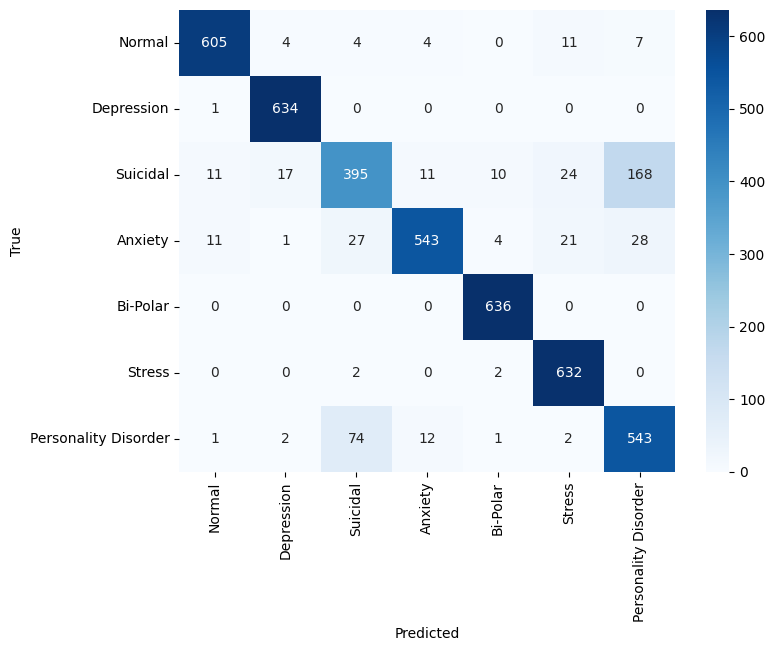

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

def full_metrics():
    model.eval()
    preds_all, labels_all = [], []

    with torch.no_grad():
        for batch in test_loader:
            inp = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["status_encoded"].to(device)

            logits = model(inp, attn)
            preds = logits.argmax(1)

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(labels_all, preds_all, target_names=list(label2id.keys())))

    cm = confusion_matrix(labels_all, preds_all)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(label2id.keys()),
                yticklabels=list(label2id.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

full_metrics()


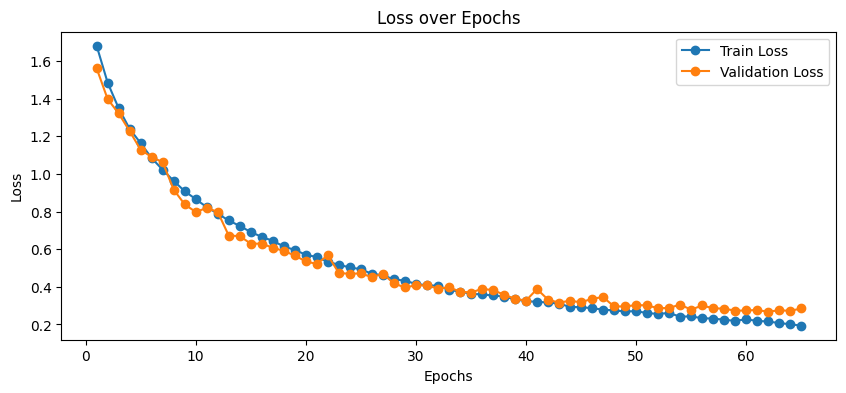

In [33]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10,4))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()



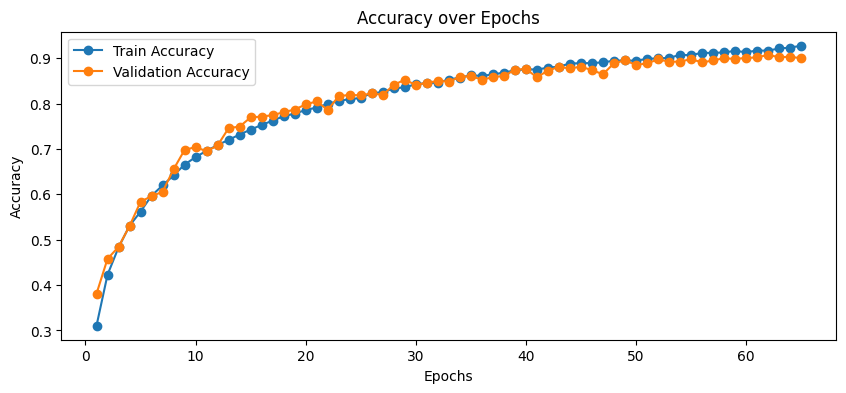

In [32]:

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(range(1, EPOCHS+1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, EPOCHS+1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()